### Import Neccessary Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb

# For data splitting
from sklearn.model_selection import train_test_split
# Import the encoder from sklearn
from sklearn.preprocessing import OneHotEncoder

# For resampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTEN

### Read Files

In [2]:
df = pd.read_csv("./datasets/google_app_scrap_cleaned2.csv")
df.head()

,APP_NAME,RATING,CATEGORY,RATING_COUNT,REVIEW_COUNT,INSTALLS,MAX_INSTALLS,FREE,PRICE,SIZE,...,DAYS_SINCE_RELEASED,SIZEBAND,PRICEBAND,DAYS_SINCE_RELEASED_RANGE,DAYS_SINCE_UPDATE_RANGE,REVIEW_PER_DAY,REVIEW_RATE,RATING_PER_DAY,RATING_RATE,INSTALLS_GROUP
0,"""Ghost Voice Catcher"" AUTO EVP",3.933333,Lifestyle,68,24.0,"1,000+",3608,False,5.99,1100000.0,...,3482.0,very small,expensive,More than 6 months,More than 6 months,0.006893,Low,0.019529,Low,Less than 100K
1,"""OXXO""",4.740000,Puzzle,975,54.0,"10,000+",21680,False,0.99,81000000.0,...,945.0,large,cheap,More than 6 months,Few days ago,0.057143,Medium,1.031746,Medium,Less than 100K
2,#DRIVE,4.434152,Racing,229679,6473.0,"5,000,000+",9119244,True,0.00,132000000.0,...,1084.0,very large,Free,More than 6 months,Few days ago,5.971402,More than once per day,211.880996,More than 50 per day,Between 100K and 10M
3,#SelfCare,4.463476,Role Playing,14932,1501.0,"1,000,000+",1209692,True,0.00,83000000.0,...,1275.0,large,Free,More than 6 months,More than 6 months,1.177255,More than once per day,11.711373,High,Between 100K and 10M
4,#open Polyamorous + ENM Dating,2.550000,Dating,708,362.0,"50,000+",93463,True,0.00,19000000.0,...,1026.0,small,Free,More than 6 months,Within 1 month,0.352827,High,0.690058,Low,Less than 100K


<a id='model building'></a>
## Model Building

First we identify the which features are usable in the dataset:

1. `AD_SUPPORTED` (cat)
2. `CATEGORY` (cat)
3. `CONTENT_RATING` (cat)
4. `DAYS_SINCE_UPDATE_RANGE` (cat)
5. `DAYS_SINCE_RELEASED` (num)
6. `DAYS_SINCE_RELEASED_RANGE` (cat)
7. `FREE` (cat)
8. `IN_APP_PURCHASES` (cat)
9. `INSTALLS` (cat)
10. `PRICEBAND` (cat)
11. `RATING_RATE` (cat)
12. `REVIEW_RATE` (cat)
13. `SIZEBAND` (cat)


In [3]:
feature_list = ["RATING_RATE", "REVIEW_RATE", "CATEGORY", "INSTALLS", "SIZEBAND", "FREE", "PRICEBAND", "AD_SUPPORTED", 
                "CONTENT_RATING", "IN_APP_PURCHASES", "DAYS_SINCE_UPDATE_RANGE", "DAYS_SINCE_RELEASED_RANGE", "DAYS_SINCE_RELEASED"]
model_df = df[feature_list].copy()
model_df.head()

,RATING_RATE,REVIEW_RATE,CATEGORY,INSTALLS,SIZEBAND,FREE,PRICEBAND,AD_SUPPORTED,CONTENT_RATING,IN_APP_PURCHASES,DAYS_SINCE_UPDATE_RANGE,DAYS_SINCE_RELEASED_RANGE,DAYS_SINCE_RELEASED
0,Low,Low,Lifestyle,"1,000+",very small,False,expensive,False,Everyone,False,More than 6 months,More than 6 months,3482.0
1,Medium,Medium,Puzzle,"10,000+",large,False,cheap,False,Everyone,False,Few days ago,More than 6 months,945.0
2,More than 50 per day,More than once per day,Racing,"5,000,000+",very large,True,Free,True,Everyone,True,Few days ago,More than 6 months,1084.0
3,High,More than once per day,Role Playing,"1,000,000+",large,True,Free,False,Teen,True,More than 6 months,More than 6 months,1275.0
4,Low,High,Dating,"50,000+",small,True,Free,False,Adults,True,Within 1 month,More than 6 months,1026.0


Handling null values

In [4]:
model_df.isna().sum()

RATING_RATE                  0
REVIEW_RATE                  0
CATEGORY                     0
INSTALLS                     0
SIZEBAND                     0
FREE                         0
PRICEBAND                    0
AD_SUPPORTED                 0
CONTENT_RATING               0
IN_APP_PURCHASES             0
DAYS_SINCE_UPDATE_RANGE      0
DAYS_SINCE_RELEASED_RANGE    0
DAYS_SINCE_RELEASED          0
dtype: int64

Seems like there are no null values in our dataset :)

In [5]:
model_df = model_df.loc[model_df["DAYS_SINCE_RELEASED"] <= 365, :]
model_df.reset_index(inplace= True, drop=True)
model_df.drop(["DAYS_SINCE_RELEASED"], inplace=True, axis=1)
model_df

,RATING_RATE,REVIEW_RATE,CATEGORY,INSTALLS,SIZEBAND,FREE,PRICEBAND,AD_SUPPORTED,CONTENT_RATING,IN_APP_PURCHASES,DAYS_SINCE_UPDATE_RANGE,DAYS_SINCE_RELEASED_RANGE
0,More than 50 per day,More than once per day,Simulation,"5,000,000+",very large,True,Free,True,Everyone,False,3 to 6 months,More than 6 months
1,More than 50 per day,More than once per day,Simulation,"10,000,000+",very large,True,Free,True,Adults,True,Within 1 month,More than 6 months
2,Medium,High,Lifestyle,"5,000+",medium,False,cheap,False,Everyone,False,Within 1 month,3 to 6 months
3,Medium,High,Trivia,"100,000+",medium,True,Free,True,Everyone,True,More than 6 months,More than 6 months
4,Medium,Medium,Tools,"50,000+",small,False,cheap,False,Everyone,False,Few days ago,More than 6 months
...,...,...,...,...,...,...,...,...,...,...,...,...
2976,Low,Medium,Simulation,"1,000+",very small,True,Free,False,Teen,True,1 to 3 months,1 to 3 months
2977,More than 50 per day,Medium,Role Playing,"100,000+",medium,True,Free,False,Teen,True,3 to 6 months,More than 6 months
2978,High,Medium,Role Playing,"50,000+",very large,True,Free,False,Teen,True,Few days ago,3 to 6 months
2979,More than 50 per day,Medium,Card,"100,000+",very large,True,Free,False,Teen,True,1 to 3 months,3 to 6 months


Less than 1M    2091
More than 1M     890
Name: INSTALLS_GROUP, dtype: int64


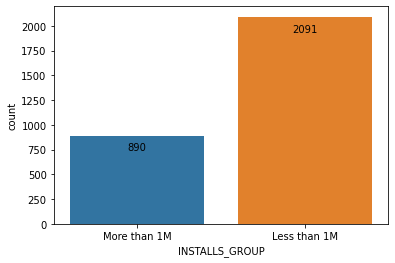

In [6]:
model_df['INSTALLS_GROUP'] = 'More than 1M'
model_df.loc[(model_df['INSTALLS'] == '1+') | (model_df['INSTALLS'] == '10+') | (model_df['INSTALLS'] == '50+') | 
       (model_df['INSTALLS'] == '100+') | (model_df['INSTALLS'] == '500+' ) | (model_df['INSTALLS'] == '1,000+' ) | 
       (model_df['INSTALLS'] == '5,000+' ) | (model_df['INSTALLS'] == '10,000+') | (model_df['INSTALLS'] == '50,000+') |
       (model_df['INSTALLS'] == '100,000+') | (model_df['INSTALLS'] == '500,000+'), 'INSTALLS_GROUP'] = 'Less than 1M'
print(model_df['INSTALLS_GROUP'] .value_counts())
sub_plot1 = sb.countplot(x="INSTALLS_GROUP", data=model_df)
for p in sub_plot1.patches:
    if p.get_height() == 0:
        sub_plot1.annotate(format(p.get_height(), '.0f'), 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha = 'center', va = 'center', 
        xytext = (0, 9), 
        textcoords = 'offset points')
    else:
        sub_plot1.annotate(format(p.get_height(), '.0f'), 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha = 'center', va = 'center', 
        xytext = (0, -12), 
        textcoords = 'offset points')

### Data Preprocessing for model

From eda, we noticed that it is unlikely to accurately predict the rating of the app, due to its nature that rating is not only affected by the features of the app, but the user experience and user interface also play an important role too. In this case, our group set the indicator for the performance of the app to how much it has been installed. 

For data preprosessing, we picked 10 predictors for predicting `INSTALLS_GROUP` that the app is going to fall into, namely
1. `AD_SUPPORTED` (cat)
2. `CATEGORY` (cat)
3. `CONTENT_RATING` (cat)
4. `DAYS_SINCE_UPDATE_RANGE` (cat)
5. `FREE` (cat)
6. `IN_APP_PURCHASES` (cat)
7.  `PRICEBAND` (cat)
8.  `RATING_RATE` (cat)
9.  `REVIEW_RATE` (cat)
10. `SIZEBAND` (cat)

Before we continue, we need to do some changes on `CATEGORY`.

For `CATEGORY`, we noticed from eda that most apps falls under "Game" category, with that we change the category values to either "Game" or "Non Game"

In [7]:
model_df.loc[model_df["CATEGORY"] != "Game", "CATEGORY"] = "Non Game"
model_df["CATEGORY"].value_counts()

Non Game    2981
Name: CATEGORY, dtype: int64

**Split the dataset into train and test data**

In [8]:
# Extract Response and Predictors
response = "INSTALLS_GROUP"
y = pd.DataFrame(model_df[response])
X = pd.DataFrame(model_df.drop(response, axis = 1))

# Split the dataset into 75% train and 25% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=20)

y_train.value_counts()

INSTALLS_GROUP
Less than 1M      1571
More than 1M       664
dtype: int64

In [9]:
# concat training data
train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
train_df.head()

,RATING_RATE,REVIEW_RATE,CATEGORY,INSTALLS,SIZEBAND,FREE,PRICEBAND,AD_SUPPORTED,CONTENT_RATING,IN_APP_PURCHASES,DAYS_SINCE_UPDATE_RANGE,DAYS_SINCE_RELEASED_RANGE,INSTALLS_GROUP
0,More than 50 per day,More than once per day,Non Game,"1,000,000+",very large,True,Free,True,Everyone,True,3 to 6 months,More than 6 months,More than 1M
1,More than 50 per day,More than once per day,Non Game,"5,000,000+",medium,True,Free,True,Adults,False,Almost a week,More than 6 months,More than 1M
2,More than 50 per day,More than once per day,Non Game,"5,000,000+",very large,True,Free,True,Teen,False,Within 1 month,More than 6 months,More than 1M
3,High,High,Non Game,"1,000,000+",small,True,Free,True,Everyone,False,1 to 3 months,1 to 3 months,More than 1M
4,Low,Low,Non Game,"1,000+",very large,False,cheap,False,Teen,False,3 to 6 months,More than 6 months,Less than 1M


### Resampling INSTALLS_GROUP

We noticed that there is an imbalanced distribution of `INSTALLS_GROUP`, we handle them by oversampling techniques below.
1. Random Oversampling
2. SMOTEN

In [10]:
y_train.value_counts()

INSTALLS_GROUP
Less than 1M      1571
More than 1M       664
dtype: int64

**Random Oversampling**

We will resample the data to equal portions

In [11]:
strategy = {"Less than 1M": 2000, 
            "More than 1M": 2000,}
over_sampler = RandomOverSampler(sampling_strategy=strategy, random_state=20)
X_over, y_over = over_sampler.fit_resample(X_train, y_train)

y_over.value_counts()

C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\utils\_validation.py:299: UserWarning: After over-sampling, the number of samples (2000) in class Less than 1M will be larger than the number of samples in the majority class (class #Less than 1M -> 1571)
  warnings.warn(
C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\utils\_validation.py:299: UserWarning: After over-sampling, the number of samples (2000) in class More than 1M will be larger than the number of samples in the majority class (class #Less than 1M -> 1571)
  warnings.warn(


INSTALLS_GROUP
Less than 1M      2000
More than 1M      2000
dtype: int64

In [12]:
train_oversampled_df = pd.concat([X_over, y_over], axis=1)
train_oversampled_df.head()

,RATING_RATE,REVIEW_RATE,CATEGORY,INSTALLS,SIZEBAND,FREE,PRICEBAND,AD_SUPPORTED,CONTENT_RATING,IN_APP_PURCHASES,DAYS_SINCE_UPDATE_RANGE,DAYS_SINCE_RELEASED_RANGE,INSTALLS_GROUP
0,More than 50 per day,More than once per day,Non Game,"1,000,000+",very large,True,Free,True,Everyone,True,3 to 6 months,More than 6 months,More than 1M
1,More than 50 per day,More than once per day,Non Game,"5,000,000+",medium,True,Free,True,Adults,False,Almost a week,More than 6 months,More than 1M
2,More than 50 per day,More than once per day,Non Game,"5,000,000+",very large,True,Free,True,Teen,False,Within 1 month,More than 6 months,More than 1M
3,High,High,Non Game,"1,000,000+",small,True,Free,True,Everyone,False,1 to 3 months,1 to 3 months,More than 1M
4,Low,Low,Non Game,"1,000+",very large,False,cheap,False,Teen,False,3 to 6 months,More than 6 months,Less than 1M


**SMOTEN Oversampling** 

Since our data are purely categorical, we apply the SMOTEN oversampling technique to resample our data.

In [13]:
strategy = {"Less than 1M": 2000, 
            "More than 1M": 2000,}
smoten_sampler = SMOTEN(sampling_strategy=strategy, random_state=20)
X_smoten, y_smoten = smoten_sampler.fit_resample(X_train, y_train)

y_smoten.value_counts()

C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\utils\_validation.py:299: UserWarning: After over-sampling, the number of samples (2000) in class Less than 1M will be larger than the number of samples in the majority class (class #Less than 1M -> 1571)
  warnings.warn(
C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\utils\_validation.py:299: UserWarning: After over-sampling, the number of samples (2000) in class More than 1M will be larger than the number of samples in the majority class (class #Less than 1M -> 1571)
  warnings.warn(


INSTALLS_GROUP
Less than 1M      2000
More than 1M      2000
dtype: int64

In [14]:
train_smoten_df = pd.concat([X_smoten, y_smoten], axis=1)
train_smoten_df.head()

,RATING_RATE,REVIEW_RATE,CATEGORY,INSTALLS,SIZEBAND,FREE,PRICEBAND,AD_SUPPORTED,CONTENT_RATING,IN_APP_PURCHASES,DAYS_SINCE_UPDATE_RANGE,DAYS_SINCE_RELEASED_RANGE,INSTALLS_GROUP
0,More than 50 per day,More than once per day,Non Game,"1,000,000+",very large,True,Free,True,Everyone,True,3 to 6 months,More than 6 months,More than 1M
1,More than 50 per day,More than once per day,Non Game,"5,000,000+",medium,True,Free,True,Adults,False,Almost a week,More than 6 months,More than 1M
2,More than 50 per day,More than once per day,Non Game,"5,000,000+",very large,True,Free,True,Teen,False,Within 1 month,More than 6 months,More than 1M
3,High,High,Non Game,"1,000,000+",small,True,Free,True,Everyone,False,1 to 3 months,1 to 3 months,More than 1M
4,Low,Low,Non Game,"1,000+",very large,False,cheap,False,Teen,False,3 to 6 months,More than 6 months,Less than 1M


**Combining test_df**

In [15]:
test_df = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)
test_df.head()

,RATING_RATE,REVIEW_RATE,CATEGORY,INSTALLS,SIZEBAND,FREE,PRICEBAND,AD_SUPPORTED,CONTENT_RATING,IN_APP_PURCHASES,DAYS_SINCE_UPDATE_RANGE,DAYS_SINCE_RELEASED_RANGE,INSTALLS_GROUP
0,More than 50 per day,More than once per day,Non Game,"500,000+",very large,True,Free,False,Teen,True,Few days ago,Within 1 month,Less than 1M
1,More than 50 per day,More than once per day,Non Game,"1,000,000+",medium,True,Free,True,Everyone,True,Within 1 month,1 to 3 months,More than 1M
2,Medium,Medium,Non Game,"50,000+",small,True,Free,True,Everyone,False,3 to 6 months,3 to 6 months,Less than 1M
3,High,Medium,Non Game,"100,000+",medium,True,Free,True,Everyone,True,Almost a week,Within 1 month,Less than 1M
4,High,Medium,Non Game,"1,000,000+",medium,True,Free,True,Everyone,True,Within 1 month,More than 6 months,More than 1M


#### Encoding categorical values

Before we continue, our categorical variables are further divided into 2 types —
- Ordinal categorical variables - `INSTALLS_GROUP`, `SIZEBAND`, `PRICEBAND`, `RATING_GROUP`,`FREE`, `AD_SUPPORTED`, `IN_APP_PURCHASES`, `EDITORS_CHOICE`
- Nominal categorical variable - `CATEGORY`,  `CONTENT_RATING`

In [16]:
nominal_cat = ["CATEGORY", "CONTENT_RATING"]
ordinal_cat = ["FREE","AD_SUPPORTED", "INSTALLS_GROUP", "PRICEBAND", "SIZEBAND", "IN_APP_PURCHASES", "DAYS_SINCE_UPDATE_RANGE", "REVIEW_RATE", "RATING_RATE"]

numerical = []

**Function for handling Ordinal Categorical Variables**

In [17]:
def encode_ord_cat(df):
    # label encoding
    ig_mapping = {"Less than 1M": 0, "More than 1M": 1}
    pb_mapping = {"Free": 0, "cheap": 1, "normal": 2, "expensive": 3, "very expensive": 4}
    sb_mapping = {"very small": 0, "small": 1, "medium": 2, "large": 3, "very large": 4}
    dsu_mapping = {"Few days ago": 0, "Almost a week": 1, "Within 1 month": 2, "1 to 3 months": 3, "3 to 6 months": 4, "More than 6 months": 5}
    revr_mapping = {"Low": 0, "Medium": 1, "High": 2, "More than once per day": 3}
    ratr_mapping = {"Low": 0, "Medium": 1, "High": 2, "More than 50 per day": 3}
    free_mapping = {False: 0, True: 1}
    ads_mapping = {False: 0, True: 1}
    iap_mapping = {False: 0, True: 1}
    
    model_df_ord = df.copy()
    
    model_df_ord["INSTALLS_GROUP"] = model_df_ord["INSTALLS_GROUP"].map(ig_mapping)
    model_df_ord["PRICEBAND"] = model_df_ord["PRICEBAND"].map(pb_mapping)
    model_df_ord["SIZEBAND"] = model_df_ord["SIZEBAND"].map(sb_mapping)
    model_df_ord["FREE"] = model_df_ord["FREE"].map(free_mapping)
    model_df_ord["AD_SUPPORTED"] = model_df_ord["AD_SUPPORTED"].map(ads_mapping)
    model_df_ord["IN_APP_PURCHASES"] = model_df_ord["IN_APP_PURCHASES"].map(iap_mapping)
    model_df_ord["DAYS_SINCE_UPDATE_RANGE"] = model_df_ord["DAYS_SINCE_UPDATE_RANGE"].map(dsu_mapping)
    model_df_ord["REVIEW_RATE"] = model_df_ord["REVIEW_RATE"].map(revr_mapping)
    model_df_ord["RATING_RATE"] = model_df_ord["RATING_RATE"].map(ratr_mapping)
    
    return model_df_ord

**Function for handling Nominal Categorical Variables**

In [18]:
def encode_norm_cat(df):
    ohe = OneHotEncoder()
    model_df_cat = df[nominal_cat]
    ohe.fit(model_df_cat)
    model_df_cat_ohe = pd.DataFrame(ohe.transform(model_df_cat).toarray(), 
                                    columns=ohe.get_feature_names_out(model_df_cat.columns))
    return model_df_cat_ohe

**Encode all datasets**

In [19]:
model_df_ord = encode_ord_cat(train_df)[ordinal_cat]
model_df_norm = encode_norm_cat(train_df)
model_df_num = train_df[numerical]
# Combine all features
train_df_encoded = pd.concat([ model_df_norm, model_df_ord, model_df_num], 
                        sort = False, axis = 1).reindex(index=model_df_ord.index)
train_df_encoded.head()

,CATEGORY_Non Game,CONTENT_RATING_Adults,CONTENT_RATING_Everyone,CONTENT_RATING_Teen,FREE,AD_SUPPORTED,INSTALLS_GROUP,PRICEBAND,SIZEBAND,IN_APP_PURCHASES,DAYS_SINCE_UPDATE_RANGE,REVIEW_RATE,RATING_RATE
0,1.0,0.0,1.0,0.0,1,1,1,0,4,1,4,3,3
1,1.0,1.0,0.0,0.0,1,1,1,0,2,0,1,3,3
2,1.0,0.0,0.0,1.0,1,1,1,0,4,0,2,3,3
3,1.0,0.0,1.0,0.0,1,1,1,0,1,0,3,2,2
4,1.0,0.0,0.0,1.0,0,0,0,1,4,0,4,0,0


In [20]:
model_df_ord = encode_ord_cat(train_oversampled_df)[ordinal_cat]
model_df_norm = encode_norm_cat(train_oversampled_df)
model_df_num = train_oversampled_df[numerical]
train_df_oversampled_encoded = pd.concat([ model_df_norm, model_df_ord, model_df_num], 
                        sort = False, axis = 1).reindex(index=model_df_ord.index)
train_df_oversampled_encoded.head()

,CATEGORY_Non Game,CONTENT_RATING_Adults,CONTENT_RATING_Everyone,CONTENT_RATING_Teen,FREE,AD_SUPPORTED,INSTALLS_GROUP,PRICEBAND,SIZEBAND,IN_APP_PURCHASES,DAYS_SINCE_UPDATE_RANGE,REVIEW_RATE,RATING_RATE
0,1.0,0.0,1.0,0.0,1,1,1,0,4,1,4,3,3
1,1.0,1.0,0.0,0.0,1,1,1,0,2,0,1,3,3
2,1.0,0.0,0.0,1.0,1,1,1,0,4,0,2,3,3
3,1.0,0.0,1.0,0.0,1,1,1,0,1,0,3,2,2
4,1.0,0.0,0.0,1.0,0,0,0,1,4,0,4,0,0


In [21]:
model_df_ord = encode_ord_cat(train_smoten_df)[ordinal_cat]
model_df_norm = encode_norm_cat(train_smoten_df)
model_df_num = train_smoten_df[numerical]
train_df_smoten_encoded = pd.concat([ model_df_norm, model_df_ord, model_df_num], 
                        sort = False, axis = 1).reindex(index=model_df_ord.index)
train_df_smoten_encoded.head()

,CATEGORY_Non Game,CONTENT_RATING_Adults,CONTENT_RATING_Everyone,CONTENT_RATING_Teen,FREE,AD_SUPPORTED,INSTALLS_GROUP,PRICEBAND,SIZEBAND,IN_APP_PURCHASES,DAYS_SINCE_UPDATE_RANGE,REVIEW_RATE,RATING_RATE
0,1.0,0.0,1.0,0.0,1,1,1,0,4,1,4,3,3
1,1.0,1.0,0.0,0.0,1,1,1,0,2,0,1,3,3
2,1.0,0.0,0.0,1.0,1,1,1,0,4,0,2,3,3
3,1.0,0.0,1.0,0.0,1,1,1,0,1,0,3,2,2
4,1.0,0.0,0.0,1.0,0,0,0,1,4,0,4,0,0


In [22]:
model_df_ord = encode_ord_cat(test_df)[ordinal_cat]
model_df_norm = encode_norm_cat(test_df)
model_df_num = test_df[numerical]
test_df_encoded = pd.concat([ model_df_norm, model_df_ord, model_df_num], 
                        sort = False, axis = 1).reindex(index=model_df_ord.index)
test_df_encoded.head()

,CATEGORY_Non Game,CONTENT_RATING_Adults,CONTENT_RATING_Everyone,CONTENT_RATING_Teen,FREE,AD_SUPPORTED,INSTALLS_GROUP,PRICEBAND,SIZEBAND,IN_APP_PURCHASES,DAYS_SINCE_UPDATE_RANGE,REVIEW_RATE,RATING_RATE
0,1.0,0.0,0.0,1.0,1,0,0,0,4,1,0,3,3
1,1.0,0.0,1.0,0.0,1,1,1,0,2,1,2,3,3
2,1.0,0.0,1.0,0.0,1,1,0,0,1,0,4,1,1
3,1.0,0.0,1.0,0.0,1,1,0,0,2,1,1,1,2
4,1.0,0.0,1.0,0.0,1,1,1,0,2,1,2,1,2


In [23]:
train_df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2235 entries, 0 to 2234
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CATEGORY_Non Game        2235 non-null   float64
 1   CONTENT_RATING_Adults    2235 non-null   float64
 2   CONTENT_RATING_Everyone  2235 non-null   float64
 3   CONTENT_RATING_Teen      2235 non-null   float64
 4   FREE                     2235 non-null   int64  
 5   AD_SUPPORTED             2235 non-null   int64  
 6   INSTALLS_GROUP           2235 non-null   int64  
 7   PRICEBAND                2235 non-null   int64  
 8   SIZEBAND                 2235 non-null   int64  
 9   IN_APP_PURCHASES         2235 non-null   int64  
 10  DAYS_SINCE_UPDATE_RANGE  2235 non-null   int64  
 11  REVIEW_RATE              2235 non-null   int64  
 12  RATING_RATE              2235 non-null   int64  
dtypes: float64(4), int64(9)
memory usage: 227.1 KB


The categorical variables are now encoded, and is ready for machine learning :)

### Export the files

In [24]:
file_path = "./datasets/train.csv"
train_df_encoded.to_csv(path_or_buf=file_path, index=False);

file_path = "./datasets/train_oversampled.csv"
train_df_oversampled_encoded.to_csv(path_or_buf=file_path, index=False);

file_path = "./datasets/train_smoten.csv"
train_df_smoten_encoded.to_csv(path_or_buf=file_path, index=False);

file_path = "./datasets/test.csv"
test_df_encoded.to_csv(path_or_buf=file_path, index=False);